## Using CUDA for Numerical Computing

### Announcements from GTC 2025 with CUDA for every industry
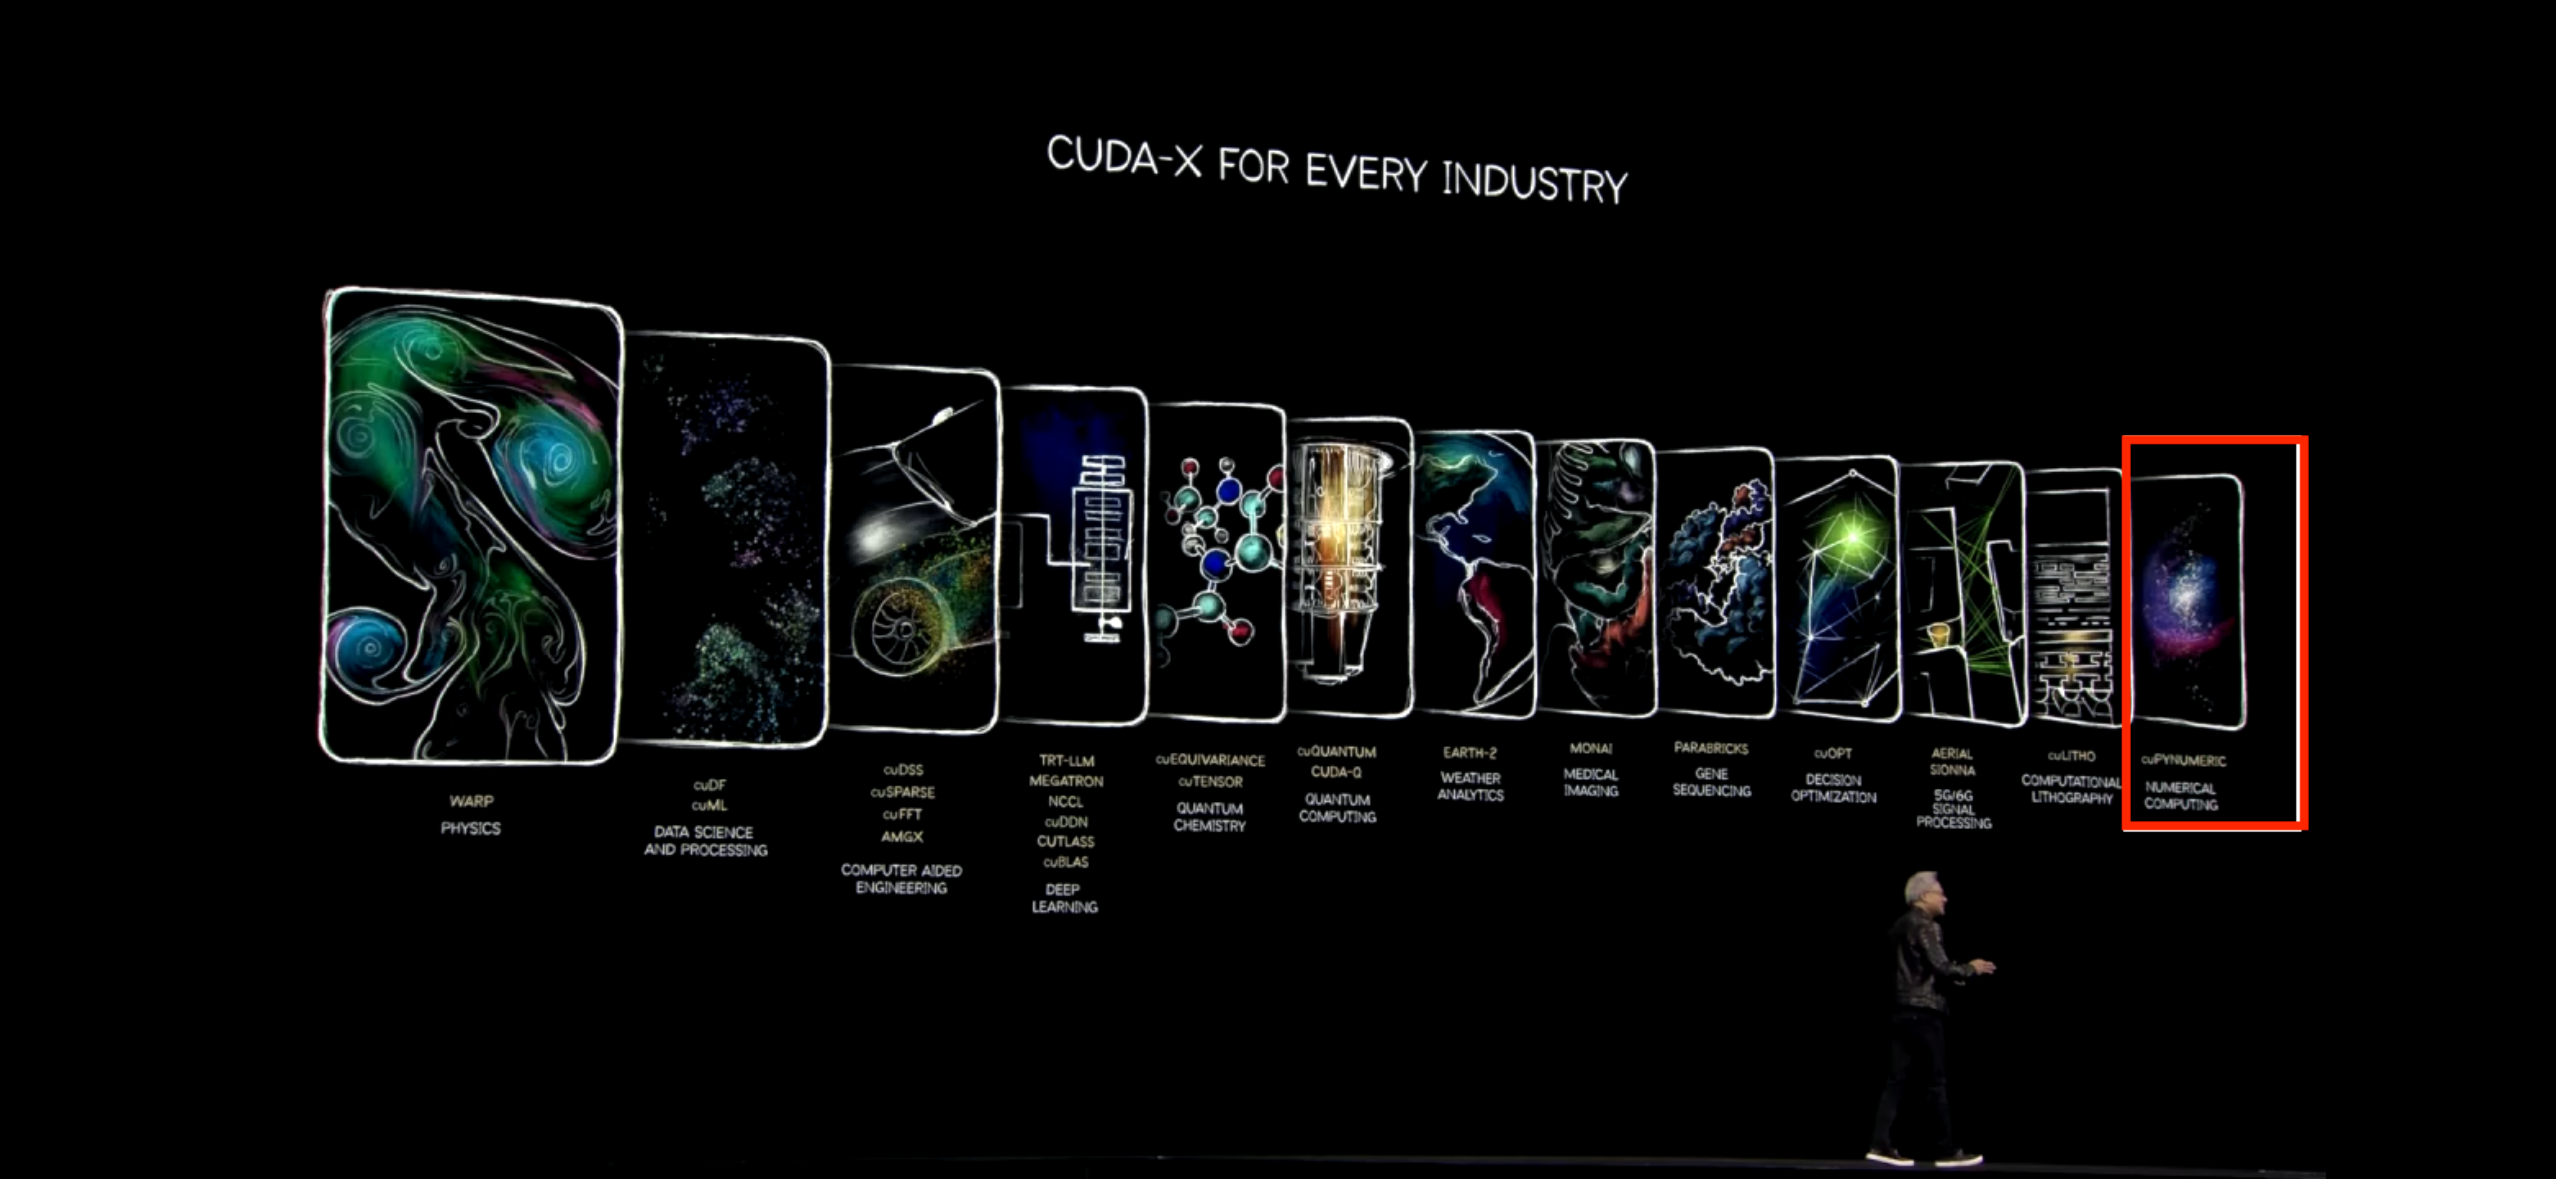

### Add a GPU - You can do this from several platforms but using Vertex Workbench on Google Cloud - https://cloud.google.com/vertex-ai-notebooks?hl=en
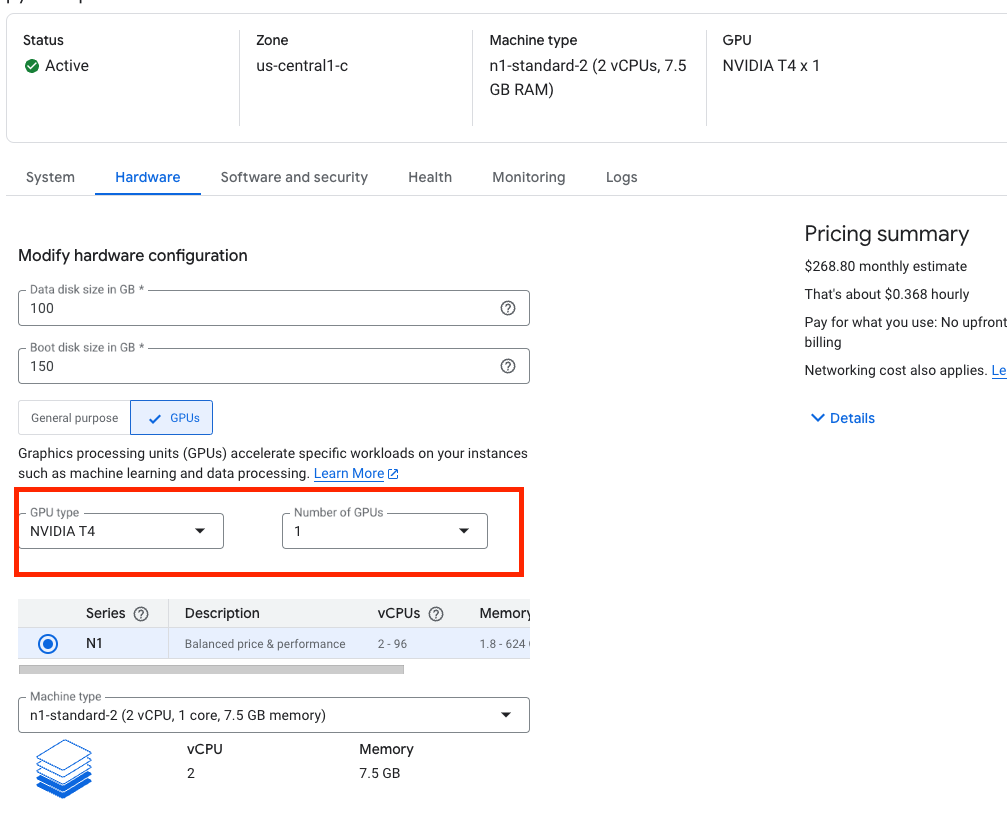

If you set it up correctly, you should be able to see your machine summary like this
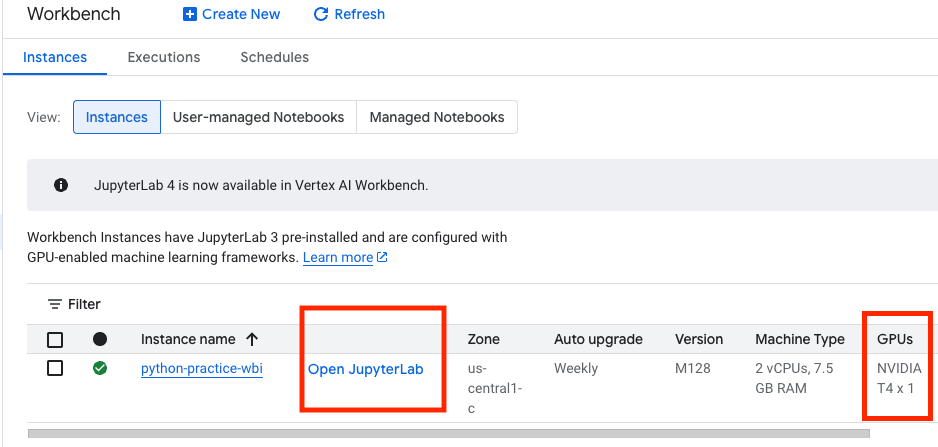

### Use this link to install the appropriate cuda for your machine - https://docs.rapids.ai/install/

In [1]:
# this vary depending on your machine and version
# !pip install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu11==25.2.*" "dask-cudf-cu11==25.2.*" "cuml-cu11==25.2.*" \
#     "cugraph-cu11==25.2.*" "nx-cugraph-cu11==25.2.*" "cuspatial-cu11==25.2.*" \
#     "cuproj-cu11==25.2.*" "cuxfilter-cu11==25.2.*" "cucim-cu11==25.2.*" \
#     "pylibraft-cu11==25.2.*" "raft-dask-cu11==25.2.*" "cuvs-cu11==25.2.*" \
#     "nx-cugraph-cu11==25.2.*"

In [2]:
#Verify the installation
!pip freeze | grep cudf

cudf-cu11==25.2.2
cudf-cu12==25.2.2
dask-cudf-cu11==25.2.2
dask-cudf-cu12==25.2.2
libcudf-cu11==25.2.2
libcudf-cu12==25.2.2
pylibcudf-cu11==25.2.2
pylibcudf-cu12==25.2.2


In [3]:
# quick look at your GPU setup - Nvidia Tesla T4 
!nvidia-smi

Thu Mar 20 15:23:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             31W /   70W |     441MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
#load CUDA
%load_ext cudf.pandas

In [5]:
#load pandas and check it is using CUDA
import pandas as pd
%whos

Variable   Type      Data/Info
------------------------------
pd         module    <module 'pandas' (ModuleA<...>fast=cudf, slow=pandas))>


In [6]:
#load libraries
import numpy as np
from time import time
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn import linear_model, model_selection, preprocessing
from sklearn.model_selection import KFold

In [7]:
raw = pd.read_csv("ames-housing-dataset.zip", compression="zip", header=0)
raw

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,...,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,142500
2926,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,...,0,NaN,MnPrv,NaN,0,6,2006,WD,Normal,131000
2927,2928,923400125,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,132000
2928,2929,924100070,20,RL,77.0,10010,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,170000


In [8]:
# Machine Learning Steps
# 1. Explore the Data (EDA)
# 2. Create predictors (X) and target variable (y)
# 3. Split your data into training, and testing dataset
# 4. Create a pipeline as a baseline you can improve later
# 5. Fit your model and score the model (R2 score - coefficient of determination and others)

# Advanced Steps
# 6. Feature engineering - convert categorical to numeric variables & fill in missing values & Hyperparameter tuning
# 7. Run your prediction on a new set of data the model has not seen before

In [9]:
# 1. Explore the Data (EDA)
raw.describe()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
count,2930.00000,2.930000e+03,2930.000000,2440.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2907.000000,...,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000,2930.000000
mean,1465.50000,7.144645e+08,57.387372,69.224590,10147.921843,6.094881,5.563140,1971.356314,1984.266553,101.896801,...,93.751877,47.533447,23.011604,2.592491,16.002048,2.243345,50.635154,6.216041,2007.790444,180796.060068
std,845.96247,1.887308e+08,42.638025,23.365335,7880.017759,1.411026,1.111537,30.245361,20.860286,179.112611,...,126.361562,67.483400,64.139059,25.141331,56.087370,35.597181,566.344288,2.714492,1.316613,79886.692357
min,1.00000,5.263011e+08,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,12789.000000
25%,733.25000,5.284770e+08,20.000000,58.000000,7440.250000,5.000000,5.000000,1954.000000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129500.000000
50%,1465.50000,5.354536e+08,50.000000,68.000000,9436.500000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,160000.000000
75%,2197.75000,9.071811e+08,70.000000,80.000000,11555.250000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213500.000000
max,2930.00000,1.007100e+09,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000


In [10]:
# 1. Explore the Data (EDA) - Look at the correlation
raw.corr(method='spearman', numeric_only=True).style.background_gradient(cmap='RdBu', vmin=-1, vmax=1)

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,TotRms AbvGrd,Fireplaces,Garage Yr Blt,Garage Cars,Garage Area,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice
Order,1.000000,0.205863,0.015074,-0.024209,0.012684,-0.049175,-0.015534,-0.056978,-0.084144,-0.041604,-0.034229,-0.018105,0.007011,-0.023661,-0.007155,-0.003142,0.026532,-0.023809,-0.041665,0.019375,-0.048754,-0.036492,0.014230,-0.015031,0.001629,-0.022008,-0.056211,-0.037003,-0.034251,-0.025811,0.000760,0.025225,-0.015117,0.006032,0.047986,-0.038106,0.142150,-0.977264,-0.035703
PID,0.205863,1.000000,-0.026875,-0.096820,-0.040342,-0.314353,0.111922,-0.314979,-0.208414,-0.237169,-0.050349,0.012860,-0.131413,-0.188111,-0.130427,-0.069092,0.047204,-0.165111,-0.009074,0.035377,-0.235566,-0.186542,-0.014036,0.084954,-0.130301,-0.151539,-0.274242,-0.276663,-0.207054,-0.092368,-0.176972,0.152769,0.005809,0.006353,0.003222,0.018754,-0.051290,0.003198,-0.270660
MS SubClass,0.015074,-0.026875,1.000000,-0.363408,-0.320550,0.103475,-0.065550,0.035632,0.015590,-0.009247,-0.098222,-0.093004,-0.113501,-0.300856,-0.278139,0.478281,0.059254,0.186612,-0.040172,0.004709,0.198671,0.266447,0.056779,0.269444,0.137183,0.010696,0.084325,0.020071,-0.047607,0.019062,0.030639,-0.005318,-0.033196,-0.039486,-0.001964,-0.031959,0.014999,-0.021873,0.001973
Lot Frontage,-0.024209,-0.096820,-0.363408,1.000000,0.659412,0.223162,-0.104785,0.192888,0.134932,0.275334,0.156582,0.044513,0.092700,0.375535,0.442289,0.000692,-0.042646,0.361933,0.103704,-0.029865,0.209843,0.077310,0.288409,0.010360,0.362169,0.248728,0.126930,0.348630,0.375849,0.118401,0.173802,-0.092787,0.010447,0.086195,0.083211,0.037856,0.013041,0.003559,0.397980
Lot Area,0.012684,-0.040342,-0.320550,0.659412,1.000000,0.196855,-0.079006,0.121151,0.103266,0.205822,0.171376,0.057461,0.068211,0.352739,0.439129,0.064565,-0.016875,0.418321,0.106726,0.009234,0.224679,0.128025,0.298550,-0.025662,0.383795,0.311907,0.073598,0.344115,0.370980,0.177609,0.171777,-0.042467,0.029028,0.091527,0.083071,0.073861,0.004774,-0.021720,0.429249
Overall Qual,-0.049175,-0.314353,0.103475,0.223162,0.196855,1.000000,-0.189638,0.664590,0.579323,0.423202,0.179239,-0.091898,0.239273,0.472852,0.415988,0.237677,-0.050242,0.577780,0.148886,-0.047082,0.556720,0.294043,0.077886,-0.170318,0.378023,0.419263,0.638166,0.611424,0.547140,0.290231,0.440433,-0.192093,0.019398,0.026212,0.033057,-0.076443,0.029163,-0.017015,0.808800
Overall Cond,-0.015534,0.111922,-0.065550,-0.104785,-0.079006,-0.189638,1.000000,-0.422306,-0.075119,-0.181996,-0.020644,0.095954,-0.123413,-0.223382,-0.187027,-0.012957,0.018427,-0.189100,-0.045087,0.089080,-0.282743,-0.106949,-0.012151,-0.084478,-0.126437,-0.056648,-0.395204,-0.258175,-0.216048,-0.036363,-0.175446,0.134745,0.044303,0.050333,-0.020386,0.061434,-0.006480,0.039612,-0.165657
Year Built,-0.056978,-0.314979,0.035632,0.192888,0.121151,0.664590,-0.422306,1.000000,0.707678,0.398747,0.214515,-0.095639,0.124441,0.442113,0.324522,0.022695,-0.123324,0.317367,0.187555,-0.054695,0.536116,0.265468,-0.032275,-0.129373,0.181709,0.199048,0.900386,0.600675,0.533612,0.296569,0.402890,-0.434250,0.011180,-0.066507,0.004203,-0.079103,0.016111,-0.009527,0.680822
Year Remod/Add,-0.084144,-0.208414,0.015590,0.134932,0.103266,0.579323,-0.075119,0.707678,1.000000,0.249285,0.087763,-0.116761,0.167045,0.309842,0.250180,0.090110,-0.058727,0.318917,0.120280,-0.057018,0.455856,0.179883,-0.032359,-0.144737,0.207894,0.148938,0.742208,0.460615,0.409481,0.249966,0.372293,-0.268871,0.049288,-0.058677,-0.011139,-0.057701,0.014296,0.041084,0.601454
Mas Vnr Area,-0.041604,-0.237169,-0.009247,0.275334,0.205822,0.423202,-0.181996,0.398747,0.249285,1.000000,0.270651,-0.028671,0.055245,

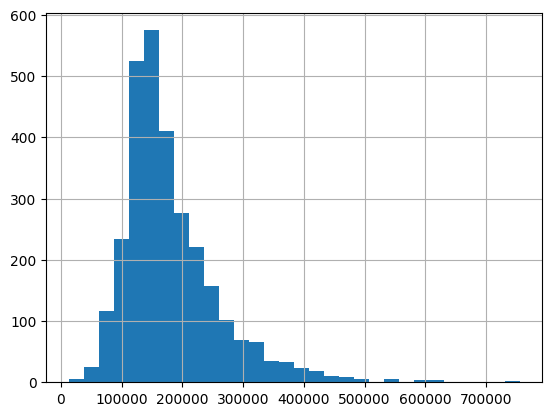

In [11]:
# 2. Create predictors (X) and target variable (y)
# Numerical - price looks normal in distribution
(raw
.SalePrice
.hist(bins=30)
);

<Axes: xlabel='SalePrice', ylabel='1st Flr SF'>

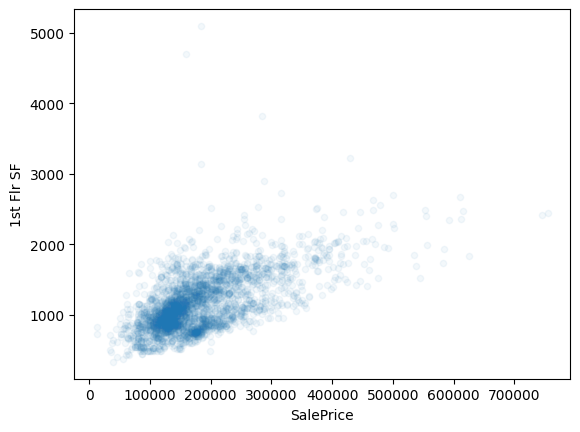

In [12]:
# the linear relationship between price and variables here
(raw
.plot
.scatter(x='SalePrice', y='1st Flr SF', alpha=.05)
)

In [13]:
# 2. Create predictors (X) and target variable (y)
def clean_housing_no_na(df):
    return (df
            .assign(**df.select_dtypes('string').replace('', 'Missing').astype('category'),
                    **{'Garage Yr Blt': df['Garage Yr Blt'].clip(upper=df['Year Built'].max())})
            .pipe(lambda df_: df_.assign(**df_.select_dtypes('number').fillna(0)))
           )
           
df = clean_housing_no_na(raw)

In [14]:
%%time
# GPU time - 1.23 s
# time CPU - 1.68 s

# 3. Split your data into training, and testing dataset
# 4. Create a pipeline as a baseline you can improve later
# 5. Fit your model and score the model (R2 score - coefficient of determination and others)

X = df.select_dtypes('number').drop(columns='SalePrice')
y = df.SalePrice

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, random_state=42)

std = preprocessing.StandardScaler().set_output(transform='pandas')
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

# compared with XGBboost with or without CUDA
xg = xgb.XGBRegressor(tree_method="hist", device="cuda")
# # xg = xgb.XGBRegressor() #without GPU acceleration by CUDAx
xg.fit(X_train, y_train)
xg.score(X_test, y_test)

CPU times: user 1.39 s, sys: 164 ms, total: 1.55 s
Wall time: 2.07 s


0.9001425504684448

In [15]:
# !pip install mlflow

In [16]:
input_example = X[0:1]

In [ ]:
# Do some prediction
import mlflow
model_info = mlflow.sklearn.log_model(xg, artifact_path='xg_pipe')

In [ ]:
model_info.artifact_path

In [ ]:
!tree

In [ ]:
model_info.run_id

In [ ]:
# Prediction
model = mlflow.pyfunc.load_model(f'mlruns/0/{model_info.run_id}/artifacts/xg_pipe')

In [ ]:
model.predict(X_test)

In [ ]:
# Advanced Steps
# 6. Feature engineering - convert categorical to numeric variables & fill in missing values & Hyperparameter tuning
# 7. Run your prediction on a new set of data the model has not seen before